In [229]:
!pip install -U scikit-learn
!pip install scipy
!pip install scikit-network
!pip install pyvis

In [230]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import SVG
from pyvis.network import Network
import numpy as np
from sknetwork.clustering import Louvain, modularity, bimodularity
from sknetwork.linalg import normalize
from sknetwork.utils import bipartite2undirected, membership_matrix
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

In [231]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [232]:
dataset = pd.read_csv("drive/MyDrive/Sampled_Data/anime_final.csv",sep=",")
rating = pd.read_csv("drive/MyDrive/Sampled_Data/rating_complete_final.csv",sep=",")

## Data Analysis

In [233]:
dataset.sample(5)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
52,72,Full Metal Panic? Fumoffu,8.07,"Action, Comedy, School",Full Metal Panic? Fumoffu,フルメタル・パニック? ふもっふ,TV,12,"Aug 26, 2003 to Oct 18, 2003",Summer 2003,...,24023,37507,45884,30305,11085,4417,1332,442,194,164
53,73,Full Metal Panic! The Second Raid,7.96,"Action, Military, Mecha",Full Metal Panic! The Second Raid,フルメタル パニック！The Second Raid,TV,13,"Jul 14, 2005 to Oct 20, 2005",Summer 2005,...,14139,30146,45246,29917,9377,3127,816,235,115,129
17,27,Trinity Blood,7.32,"Action, Supernatural, Vampire",Trinity Blood,トリニティ・ブラッド,TV,24,"Apr 29, 2005 to Oct 28, 2005",Spring 2005,...,6091,9759,17761,20152,10273,5392,2250,873,456,298
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,01-Sep-01,Unknown,...,30043,49201,49505,22632,5805,1877,577,221,109,379
27,46,Rurouni Kenshin: Meiji Kenkaku Romantan - Ishi...,7.56,"Samurai, Historical, Drama, Shounen",Samurai X:The Motion Picture,るろうに剣心 -明治剣客浪漫譚- 維新志士への鎮魂歌,Movie,1,20-Dec-97,Unknown,...,2958,3683,6232,6557,2832,1310,426,129,71,59


In [234]:
rating.sample(5)

,user_id,anime_id,rating
45,42,227,10
78,6,3358,9
29,33,2954,6
36,16,516,6
13,42,6793,7


In [235]:
dataset.shape

(57, 35)

In [236]:
rating.shape

(80, 3)

defaultdict(<class 'int'>, {'Action': 34, 'Adventure': 15, 'Comedy': 28, 'Drama': 28, 'Sci-Fi': 23, 'Space': 3, 'Mystery': 4, 'Shounen': 21, 'Police': 4, 'Supernatural': 10, 'Magic': 9, 'Fantasy': 9, 'Sports': 6, 'Josei': 1, 'Romance': 16, 'Slice of Life': 5, 'Cars': 1, 'Seinen': 11, 'Horror': 5, 'Psychological': 6, 'Thriller': 1, 'Super Power': 5, 'Martial Arts': 2, 'School': 6, 'Ecchi': 3, 'Vampire': 1, 'Military': 9, 'Historical': 6, 'Dementia': 2, 'Mecha': 9, 'Demons': 2, 'Samurai': 4, 'Game': 1, 'Shoujo': 3, 'Harem': 3, 'Music': 1})


(-0.5, 1199.5, 599.5, -0.5)

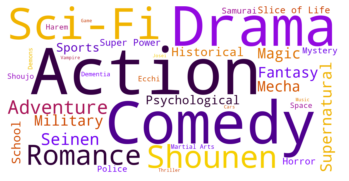

In [237]:
from collections import defaultdict

all_genres = defaultdict(int)

for genres in dataset["Genres"]:
    for genre in genres.split(','):
      
        all_genres[genre.strip()] += 1

print(all_genres)
from wordcloud import WordCloud

genres_cloud = WordCloud(width=1200, height=600, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

## Recommendation based on Clustering

In [238]:
user_row = rating['user_id'].to_numpy()
anime_col = rating['anime_id'].to_numpy()
#array = rating.to_numpy()
rating_matrix = rating.pivot_table(index='anime_id',columns='user_id',values='rating').fillna(0)
array = rating_matrix.to_numpy()

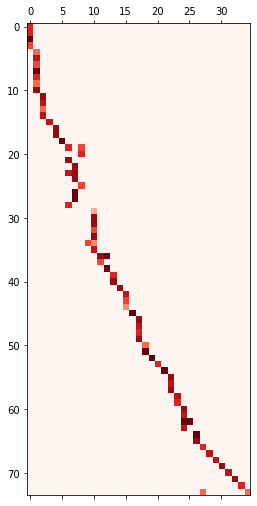

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster

model = cluster.SpectralCoclustering(n_clusters=30)
model.fit(array)
fit_X = array[np.argsort (model.row_labels_)]
fit_X = fit_X[:, np.argsort (model.column_labels_)]
plt.matshow(fit_X, cmap=plt.cm.Reds)
import pandas as pd
df = pd.DataFrame(fit_X)

In [240]:
from scipy import sparse
G = nx.Graph()
sfit = sparse.csr_matrix(fit_X)

In [241]:
# clustering
louvain = Louvain()
louvain.fit(sfit)
print(louvain)
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_
print(labels_row)

Louvain(resolution=1, modularity='dugue', tol_aggregation=0.001, n_aggregations=-1, shuffle_nodes=False, sort_clusters=True, return_membership=True, return_aggregate=True)
[ 4  4  4  4  2  2  2  2  2  2  2  5  5  5  5 21 13 13 19  0  0  0  0  0
  0  0  0  0  0  1  1  1  1  1  1  1  7  7  7 11 11 20  9  9  9 22  6  6
  6  6 15 15 16 17 18  8  8  8 14 14  3  3  3  3 12 12 10 23 24 25 26 27
 28 10]


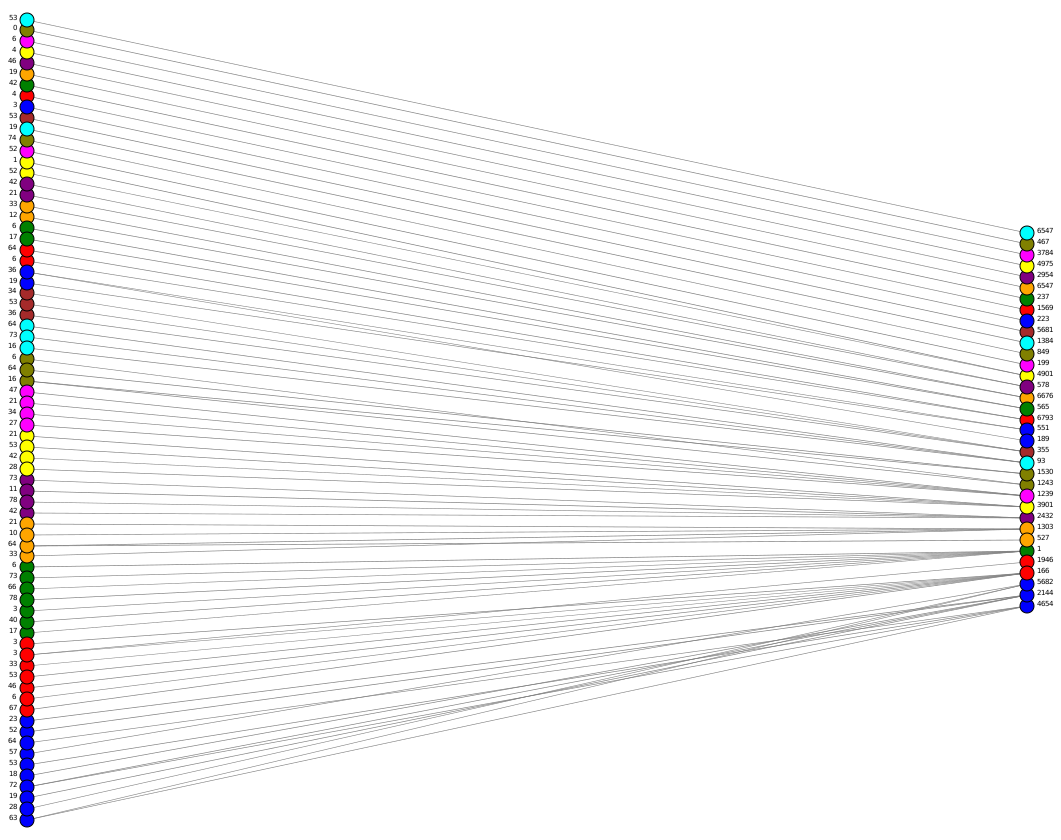

In [270]:
image = svg_bigraph(sfit, user_row, anime_col, labels_row, labels_col, height = 800, width=1000, node_size=7, edge_color='grey', edge_width_max=0.3, font_size=7)

SVG(image)

In [243]:
bimodularity(sfit, labels_row, labels_col)

0.9381129743998031

In [244]:
labels = louvain.fit_transform(sfit)
print(labels)
labels_unique, counts = np.unique(labels, return_counts=True)

[ 4  4  4  4  2  2  2  2  2  2  2  5  5  5  5 21 13 13 19  0  0  0  0  0
  0  0  0  0  0  1  1  1  1  1  1  1  7  7  7 11 11 20  9  9  9 22  6  6
  6  6 15 15 16 17 18  8  8  8 14 14  3  3  3  3 12 12 10 23 24 25 26 27
 28 10]


## Genre based Anime recommendations

In [245]:
import networkx as nx
G1 = nx.Graph()

In [246]:
#dataset.replace(['Action','Adventure','Comedy','Drama','Sci-Fi','Space','Mystery','Shounen','Police','Supernatural', 'Magic'],[0,1,2,3,4,5,6,7,8,9,10]) 
from collections import defaultdict
anime_count=0
genre_count=0
c=0
genre_list = defaultdict(int)


for index, row in dataset.iterrows():
  for genre in row['Genres'].strip().split(','):
    G1.add_edge(row['MAL_ID'],genre.strip())   

    
colors = []
genre_list = []
animeid_list = []
for node in G1:
    if node in dataset["MAL_ID"].values:
        colors.append("red")
        anime_count = anime_count + 1
        animeid_list.append(node)

    else: 
      colors.append("green") 
      genre_count=genre_count+1
      genre_list.append(node)

#print(genre_list)
#print(anime_count)
#print(genre_count)
#print(animeid_list)
#print(genre_list)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


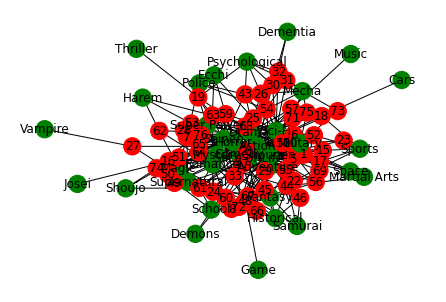

In [247]:
pos = nx.spring_layout(G1)
nx.draw(G1,pos, with_labels=1,node_color=colors)
plt.show()

In [248]:
arr = [[0 for i in range(anime_count)] for j in range(genre_count)]

for index, row in dataset.iterrows():
  for genre in row['Genres'].strip().split(','):
    arr[genre_list.index(genre.strip())][animeid_list.index(row['MAL_ID'])] = 1
    
print(arr)

[[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1], [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1], [1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

In [249]:
output = nx.Graph()
anime_w = [[0 for i in range(anime_count)] for j in range(anime_count)]

#rating_matrix = dataset.pivot_table(index='anime_id',columns='MAL_ID',values='genre')
intersection = len(list(set(arr[0][:]).intersection(arr[1][:])))
intersection=0
union = 0
weight_list = []
for i in range(0, anime_count):
  
  for k in range(i, anime_count):
    intersection=0
    union=0
    result=0
    for j in range(0, genre_count):
      if arr[j][i]==1 and arr[j][k]==1:
        intersection=intersection+1
    
      if(arr[j][i]==1 or arr[j][k]==1):
        union = union + 1
    result = intersection/union
    anime_w[i][k] = result
    weight_list.append(result)
    output.add_edge(animeid_list[i],animeid_list[k], weight = result)
    #print(intersection/union)

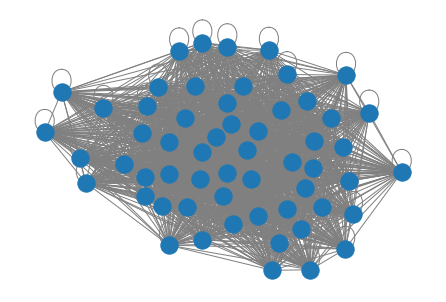

In [267]:
nx.draw(output,with_labels=0, edge_color = 'grey')
#labels = nx.get_edge_attributes(output,'weight')
#pos = nx.spring_layout(output)
#nx.draw_networkx_edge_labels(output,pos)
#nx.draw_networkx_edge_labels(output,pos,edge_labels=labels)
plt.show()

In [251]:
final = pd.DataFrame(anime_w)

In [253]:
from community import community_louvain
comms = community_louvain.best_partition(output)

Louvain clustering on Adjacency matrix

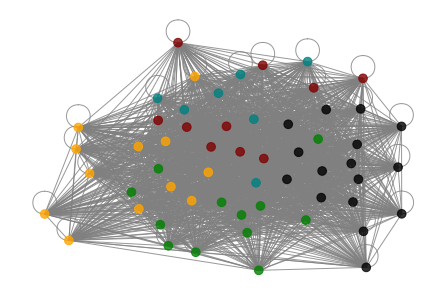

In [268]:
unique_coms = np.unique(list(comms.values()))
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'black', 
    3 : 'orange',
    4 : 'green',
    5 : 'yellow'
}

node_cmap = [cmap[v] for _,v in comms.items()]

pos = nx.spring_layout(output)
nx.draw(output, pos, node_size = 75, alpha = 0.8, node_color=node_cmap, edge_color = 'grey')
plt.show()

In [255]:
#final1 = final.to_numpy()
#type(output)
result = comms.items()
  
# Convert object to a list
data = list(result)
  
# Convert list to an array
numpyArray = np.array(data)
#modularity(numpyArray, output)

In [256]:
net = Network(notebook = True)
net.from_nx(output)
net.show("example.html")

## Get recommendations

In [257]:
element = dataset.loc[dataset['Name'] == 'Cowboy Bebop: Tengoku no Tobira']
type(int(element.iloc[0]['MAL_ID']))

int

In [258]:
def get_similar(anime_name,rating):
    similar_ratings = final[anime_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    #print(type(similar_ratings))
    return similar_ratings

In [263]:
action_lover = [("Monster",8.78)]
similar_movies = pd.DataFrame()
for movie,rating in action_lover:
    element = dataset.loc[dataset['Name'] == movie ]
    anime_id = int(element.iloc[0]['MAL_ID'])
    similar_movies = similar_movies.append(get_similar(animeid_list.index(anime_id),rating),ignore_index = True)

similar_movies.head(10)

,9,3,1,8,6,0,2,34,35,44,...,20,21,22,23,24,25,26,27,29,56
0,6.28,1.884,1.256,1.256,0.570909,0.523333,0.523333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [271]:

print("Suggested anime: ")
print("")
for col in similar_movies.iloc[:,:5].columns:
  suggested = dataset.loc[dataset['MAL_ID'] == animeid_list[col]]
  suggested_anime = suggested.iloc[0]['Name']
  print(suggested_anime)

Suggested anime: 

Monster
Witch Hunter Robin
Cowboy Bebop: Tengoku no Tobira
Initial D Fourth Stage
Hachimitsu to Clover
